In [1]:
import sys
sys.path.append('../')

In [2]:

n = 1024
order = 2
method = 'upwind'
limiter='minmod'


In [3]:
import numpy as np
from copy import copy as cp

from trafficPDE import *

import matplotlib.pyplot as plt
%matplotlib notebook
from openGLUtils import *
import matplotlib.animation
import time

from IPython.display import HTML
from ipywidgets import IntProgress
from IPython.display import display

class Plotter:
    
    def __init__(self, roads, times, order, intersections, limiter, solver):
        min_x = min(road.geo_IN[0] for road in roads)
        max_x = max(road.geo_OUT[0] for road in roads)
        self.fig, self.ax = plt.subplots()
        self.ax.axis([min_x, max_x, 0, 1.1])
        
        self.line_refs = []
        for road in roads:
            l, = self.ax.plot([],[])
            self.line_refs.append(l)
        self.roads = roads
        self.times = times
        self.order = order
        self.intersections = intersections
        self.limiter = limiter
        self.solver = solver
        
        self.progress_bar = IntProgress(min=0, max=len(self.times))
        display(self.progress_bar)
        
    def __call__(self, i):
        self.progress_bar.value += 1
        self.roads = ConsLaw(self.roads, self.intersections, 
                             self.times[i:i+2], 
                             self.limiter, self.solver,
                             self.order)
        
        for line_ref, road in zip(self.line_refs, self.roads):
            x=np.linspace(road.geo_IN[0], road.geo_OUT[0], road.n)

            
            line_ref.set_data(x, road.rho[self.order:-self.order])
            
    def start(self):
        ani = matplotlib.animation.FuncAnimation(self.fig, self,
                                                 frames=len(self.times)-2)
        return ani

    
        

def plot(roads, t, o, save):
    pl.figure(1)
    pl.clf()
    for i in range(len(roads)):
        x=np.linspace(roads[i].geo_IN[0], roads[i].geo_OUT[0], roads[i].n)
        pl.plot(x, roads[i].rho[o:-o]);
    pl.ylim([0,1.1])
    pl.title("t = "+str(t))
    if save:
        pl.savefig("sim_"+str(int(t)).zfill(4))
    else:
        pl.show()


    


def main(n,o, limiter, solver):

    roads = [Road() for i in range(5)]

    umax=1
    roads[0].initialize(n, np.array(( 0.0,0.0)), np.array((10.0,0.0)), o,  umax, 1, 0.)
    roads[1].initialize(n, np.array((10.0,0.0)), np.array((20.0,0.0)), o,  umax, 1, 0.)
    roads[2].initialize(n, np.array((20.0,0.0)), np.array((30.0,0.0)), o,  umax, 1, 0.)
    roads[4].initialize(n, np.array((30.1,0.0)), np.array((34.0,0.0)), o,  umax, 1, 0.)

    umax=.5
    roads[3].initialize(3, np.array((30.0,0.0)), np.array((30.1,0.0)), o, umax, 1, 0.)

    for i in range(5):
        roads[i].roadIn=i-1
        roads[i].roadOut=i+1
    roads[0].roadIn=-1
    roads[4].roadOut=-1

    intersections = [Intersections() for i in range(6)]

    intersections[0].initialize(np.array(([-1])), np.array(([ 0])))
    intersections[1].initialize(np.array(([ 0])), np.array(([ 1])))
    intersections[2].initialize(np.array(([ 1])), np.array(([ 2])))
    ### red light in "intersection" 3 in the time interval [0, 80]
    intersections[3].initialize(np.array(([ 2])), np.array(([ 3])), None, np.array((0,80)))
    intersections[4].initialize(np.array(([ 3])), np.array(([ 4])))
    intersections[5].initialize(np.array(([ 4])), np.array(([-1])))

    T = 200
    Tintervals = np.linspace(0.,1.*T,100)
    tshow=1
    
    
    plotter = Plotter(roads, Tintervals, o, intersections, limiter, solver)
    ani = plotter.start()
    display(HTML(ani.to_jshtml()))




   





In [4]:
main(64,order,limiter,method)

<IPython.core.display.Javascript object>

IntProgress(value=0)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

In [6]:
import copy
class Solver:
    def __init__(self, order, limiter, solver):
        
        T = 200
        Tintervals = np.linspace(0.,1.*T,100)
        self.times = Tintervals
        self.order = copy.deepcopy(order)
        self.limiter = copy.deepcopy(limiter)
        self.solver = copy.deepcopy(solver)

        self.callbacks = []
        
    def add_callback(self, callback):
        self.callbacks.append(callback)
    def __call__(self, speed_at_time):
        speeds = [1 for _ in range(5)]
        speeds[3] = speed_at_time[0]
        n=64
        total_throughput = 0
        roads = [Road() for i in range(5)]

        umax=1
        roads[0].initialize(n, np.array(( 0.0,0.0)), np.array((10.0,0.0)), self.order,  speeds[0], 1, 0.)
        roads[1].initialize(n, np.array((10.0,0.0)), np.array((20.0,0.0)), self.order,  speeds[1], 1, 0.)
        roads[2].initialize(n, np.array((20.0,0.0)), np.array((30.0,0.0)), self.order,  speeds[2], 1, 0.)
        roads[3].initialize(3, np.array((30.0,0.0)), np.array((30.1,0.0)), self.order, speeds[3], 1, 0.)
        roads[4].initialize(n, np.array((30.1,0.0)), np.array((34.0,0.0)), self.order,  speeds[4], 1, 0.)

        for i in range(5):
            roads[i].roadIn=i-1
            roads[i].roadOut=i+1
        roads[0].roadIn=-1
        roads[4].roadOut=-1

        intersections = [Intersections() for i in range(6)]

        intersections[0].initialize(np.array(([-1])), np.array(([ 0])))
        intersections[1].initialize(np.array(([ 0])), np.array(([ 1])))
        intersections[2].initialize(np.array(([ 1])), np.array(([ 2])))
        ### red light in "intersection" 3 in the time interval [0, 80]
        intersections[3].initialize(np.array(([ 2])), np.array(([ 3])), None, np.array((0,80)))
        intersections[4].initialize(np.array(([ 3])), np.array(([ 4])))
        intersections[5].initialize(np.array(([ 4])), np.array(([-1])))

        for i in range(len(self.times)-2):
            roads[3].Umax = speed_at_time[i]
            roads = ConsLaw(roads, intersections, 
                                 self.times[i:i+2], 
                                 self.limiter, self.solver,
                                 self.order)
            for road in roads:
                total_throughput += np.sum(Flux(road.rho, road.Umax, 1.0))/len(road.rho) * (road.geo_OUT[0] - road.geo_IN[0])
                
        for callback in self.callbacks:
            callback(total_throughput)
        return -total_throughput
    


In [7]:
import scipy.optimize
solver_object = Solver(order, limiter, method)

class MinimumPlotter:
    def __init__(self):
        self.maximums_per_iterations = []
        self.throughput_all = []
        self.fig, self.ax = plt.subplots(1,1)
        self.line_ref, = self.ax.plot([], [])
        self.ax.set_xlabel('Number of iterations')
        self.ax.set_ylabel('Best throughput')
    def add_throughput(self, throughput):
        self.throughput_all.append(throughput)
    
    def __call__(self, parameter):
        
        self.maximums_per_iterations.append(max(self.throughput_all))
        number_of_iterations = len(self.maximums_per_iterations)
        
        print(f"callback: {parameter}, {self.maximums_per_iterations[-1]}")
        
        self.ax.set_xlim([0, number_of_iterations])
        self.ax.set_ylim([0, max(self.maximums_per_iterations)])
        self.line_ref.set_data(np.arange(0, number_of_iterations),
                        self.maximums_per_iterations)
        
        self.fig.canvas.draw()
    

<IPython.core.display.Javascript object>


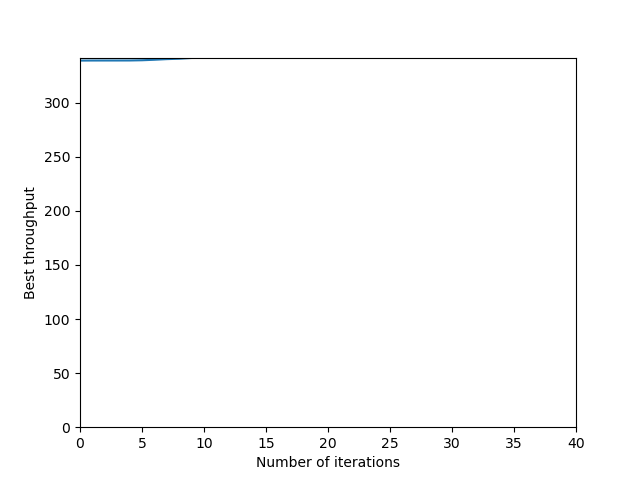

callback: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5], 338.9866389426103
callback: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.97096298 0.94288419 0.97139358
 0.97024393 0.96772909 0.96737701 0.9658257  0.96446368 0.96477033
 0.96798998 0.9742419  0.97932062 0.98564288 0.98844073 0.99494

callback: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        1.         0.32885379 0.75730725
 0.93944065 0.72064252 0.89879119 0.76377517 0.5764209  0.88416273
 0.94015542 0.99182128 0.98690672 0.99336224 0.84897183 0.73235238
 0.71401801 0.41605046 0.97601674 0.85728248 0.89901413 0.88353719
 0.49270001 0.22022098 0.9505472  0.1        0.88684954 0.9294433
 0.96223827 0.18916168 0.1        0.26893262 0.29278931 0.94272278
 1.         0.14508973 0.10198366 0.69409707 0.1        0.16959737
 0.82056783 0.14405209 0.10875245 0.95277432 0.1        0.95486323
 1.         0.32965034 0.19605642 0.98639829 0.1        0.97828018
 1.         0.78526367 0.222

callback: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.99975373 0.31523581 0.74492165
 0.92562749 0.70387985 0.88652257 0.75589633 0.57181456 0.89321924
 0.93921458 0.99887697 0.99612239 0.99940465 0.84196571 0.70338855
 0.72671065 0.38474859 0.97623557 0.8448242  0.87595432 0.8484973
 0.46964942 0.2271247  0.95229795 0.13052607 0.88516873 0.92115192
 0.9536271  0.20699935 0.13628361 0.28777821 0.31260933 0.95670685
 0.99997299 0.17481525 0.1        0.67579418 0.1        0.17089136
 0.76532046 0.15022288 0.1        0.96120506 0.10423369 0.9636773
 0.99861454 0.32121384 0.21179539 0.99646947 0.12882388 0.99166402
 1.         0.79281075 0.2431

callback: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        1.         0.34519342 0.73725067
 0.90653251 0.66907346 0.87783439 0.74898977 0.57447551 0.94190953
 0.96702886 1.         1.         1.         0.82013892 0.7009517
 0.77042479 0.40120881 0.97430953 0.83749937 0.85042364 0.78008539
 0.44003235 0.27327605 0.95570028 0.16887239 0.87224615 0.90563013
 0.90656905 0.22467465 0.17200908 0.29483296 0.32376941 0.95946017
 0.96164784 0.21049602 0.11845337 0.61470441 0.1        0.21710837
 0.67066562 0.15220968 0.1952848  0.9779083  0.10361239 0.9533908
 0.94201652 0.28344222 0.20467663 0.98222744 0.1782742  0.99308721
 0.99172051 0.7891568  0.2846

callback: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        1.         0.39957817 0.72278105
 0.90306069 0.65941694 0.86584048 0.73626311 0.56673811 0.94046687
 0.97000865 0.99483146 0.98950421 0.99794497 0.82194103 0.69693171
 0.76365211 0.42259565 0.97059675 0.83613601 0.85016018 0.76876566
 0.44139368 0.30213475 0.94202058 0.16603559 0.87255873 0.92338615
 0.90423797 0.23946636 0.16945758 0.29009211 0.32381372 0.95681554
 0.95008969 0.22084505 0.10188547 0.60089021 0.1        0.25020577
 0.65758193 0.16542961 0.16602532 0.97694183 0.1120557  0.95382423
 0.93371574 0.3050585  0.22937865 0.9789278  0.19170892 0.98787664
 0.99233884 0.78068722 0.29

In [8]:
minimum_plotter = MinimumPlotter()
speeds_initial=[0.5 for _ in solver_object.times]
speeds_bounds = [[0.1, 1.0] for _ in solver_object.times]
solver_object.add_callback(minimum_plotter.add_throughput)
best_speeds = scipy.optimize.minimize(solver_object, speeds_initial, method='L-BFGS-B', 
                                      bounds=speeds_bounds,
                                      callback=minimum_plotter
                                     )

In [9]:
best_speeds

      fun: -341.75257671169146
 hess_inv: <100x100 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.94329931e-02,
       -1.46758339e-01, -1.35156596e-01, -3.18181035e-01, -2.70443933e-01,
       -1.68540736e-01, -1.58786405e-01,  2.44759351e+05, -2.49008279e-01

In [10]:
 minimum_plotter.throughput_all
    

[330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107815650765,
 330.84107816662845,
 330.84107817672145,
 330.84107817779267,
 330.8410781769658,
 330.8410781725679,
 330.8410781739981,
 330.8410781753849,
 330.841078175062

In [11]:
roads

NameError: name 'roads' is not defined

In [ ]:
x = Road()

In [ ]:
x.initialize(n, np.array(( 0.0,0.0)), np.array((10.0,0.0)), order,  0.7, 1, 0.)

In [ ]:
x


In [ ]:
x.__dict__